# RandomForestRegressor ile Sıcaklık Tahmini
# Kullanılan veri seti hava içerisindeki bazı bileşenlerin bulunduğu ve sıcaklık değerinin RandomForestRegressor ile tahmin edildiği bir veri setidir.

Veri seti üzerinde yapılan işlemler kısaca maddeler halinde listelenmiştir:

- Boş değerlerin analizi ve doldurulması
- Tarih içeren sütunların silinmesi
- Bazı sütunlarda girilen yanlış ve eksik verilerin düzenlenmesi
- PCA analizi ile boyut indirgeme
- Korelasyon analizi ile bazı sütunların düşürülmesi
- Aykırı değerlerin normalizasyonu
- Modelin oluşturulması, eğitilmesi, test edilmesi ve metriklerine bakılması

Veriseti linki: ' http://archive.ics.uci.edu/ml/datasets/Air+Quality ' 

In [114]:
#Kullanılacak bütün kütüphaneler dahil edilir

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from warnings import filterwarnings
import seaborn as sns

In [115]:
#Uyarılar görmezden gelinir ve grafikleri sütun aralarında görmek için % inline komutu kullanılır

%matplotlib inline
filterwarnings('ignore')

In [116]:
#Data isimli değişkene csv dosyasından okunan değerler aktarılır

data = pd.read_csv("AirQualityUCI.csv", sep=";")

In [117]:
data.to_excel("Data.xlsx")

In [118]:
#Verinin ilk 10 satırı

data.head(10)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN
5,10/03/2004,23.00.00,"1,2",1197.0,38.0,"4,7",750.0,89.0,1337.0,96.0,1393.0,949.0,"11,2","59,2","0,7848",NaN,NaN
6,11/03/2004,00.00.00,"1,2",1185.0,31.0,"3,6",690.0,62.0,1462.0,77.0,1333.0,733.0,"11,3","56,8","0,7603",NaN,NaN
7,11/03/2004,01.00.00,1,1136.0,31.0,"3,3",672.0,62.0,1453.0,76.0,1333.0,730.0,"10,7","60,0","0,7702",NaN,NaN
8,11/03/2004,02.00.00,"0,9",1094.0,24.0,"2,3",609.0,45.0,1579.0,60.0,1276.0,620.0,"10,7","59,7","0,7648",NaN,NaN
9,11/03/2004,03.00.00,"0,6",1010.0,19.0,"1,7",561.0,-200.0,1705.0,-200.0,1235.0,501.0,"10,3","60,2","0,7517",NaN,NaN


In [119]:
#Bütün attribute'lerin veri tipi kontrol edilir
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(10), object(7)
memory usage: 1.2+ MB


In [120]:
#Verinin satır sütun bilgisine bakılır

data.shape

(9471, 17)

In [121]:
#Sütunlar obje veritipinden nümerik hale getirilir

data["CO(GT)"] = pd.to_numeric(data["CO(GT)"].str.replace(",","."))

In [122]:
data["C6H6(GT)"] = pd.to_numeric(data["C6H6(GT)"].str.replace(",","."))

In [123]:
data["T"] = pd.to_numeric(data["T"].str.replace(",","."))

In [124]:
data["RH"] = pd.to_numeric(data["RH"].str.replace(",","."))

In [125]:
data["AH"] = pd.to_numeric(data["AH"].str.replace(",","."))

In [126]:
#Sütunların veri tipi kontrol edilir

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


In [127]:
#null değerler kontrol edilir (114 adet satırın tamamen boş olduğu anlaşılmıştır)

data.isna().sum()

Date              114
Time              114
CO(GT)            114
PT08.S1(CO)       114
NMHC(GT)          114
C6H6(GT)          114
PT08.S2(NMHC)     114
NOx(GT)           114
PT08.S3(NOx)      114
NO2(GT)           114
PT08.S4(NO2)      114
PT08.S5(O3)       114
T                 114
RH                114
AH                114
Unnamed: 15      9471
Unnamed: 16      9471
dtype: int64

In [128]:
#Verisetinde bulunan fazla olan 2 özellik silinir

data = data.drop(labels = ["Unnamed: 15","Unnamed: 16"], axis =1)

In [129]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [130]:
#Verisetindeki null değerler yerine verilmiş -200 ve '-200' değerleri NaN ile değiştirilir

data = data.replace(to_replace=["-200", -200.0], value=np.NaN)

#Bütün sütunları boş olan bazı satılar olduğu fark edildi ve bu satılar silindi

data =data.dropna(how="all")

In [131]:
# -200 değeri NaN ile değiştirildikten sonra tekrar 
data.isnull().sum()

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [132]:
#Verisetindeki boş değerler ortalama ile doldurulur

data.fillna(data[['CO(GT)','PT08.S1(CO)','NMHC(GT)', 'C6H6(GT)','PT08.S2(NMHC)','NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)','PT08.S4(NO2)',
                  'PT08.S5(O3)', 'T', 'RH', 'AH']].fillna(data[['CO(GT)','PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)','PT08.S2(NMHC)',
                  'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)','PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH']].mean()),
                  inplace=True)

In [133]:
#Boş değer olup olmadığı kontrol edilir

data.isna().sum()

Date             0
Time             0
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64

In [134]:
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [135]:
data['Date'] = pd.to_datetime(data['Date'])

In [136]:
data["Time"] = pd.to_numeric(data["Time"].str.replace(".",""))

In [137]:
data['Time'] = data['Time'].values /10000

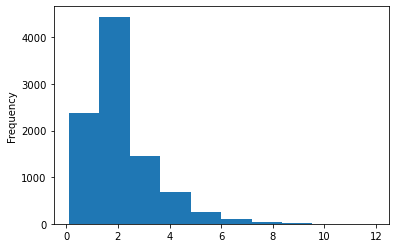

In [138]:
#CO sütunun dağılım grafiği çizilmiştir

data["CO(GT)"].plot.hist();

<IPython.core.display.Javascript object>


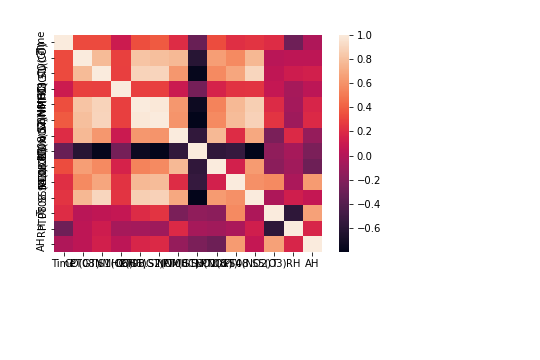

In [139]:
# Sütunların korelasyon analizi için Heatmap ile görselleştirilmiştir

%matplotlib notebook
plt.figure()
sns.heatmap(data.corr(), annot=True)
plt.show()

In [140]:
# Korelasyonu yüksek olan sütunlar veriseti'nden silinmiştir

data = data.drop(labels=['C6H6(GT)','PT08.S2(NMHC)','PT08.S5(O3)'],axis=1)

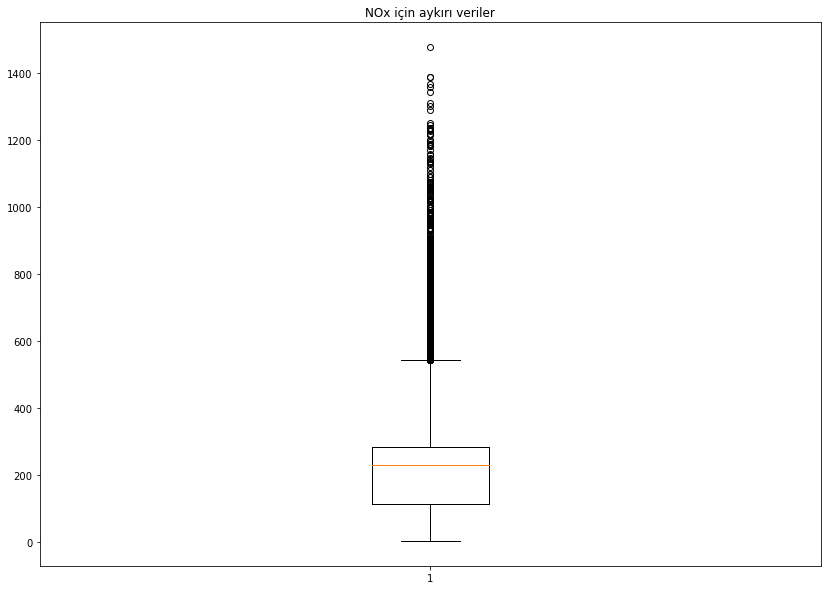

In [141]:
#Aykırı veri analizi için boxplot ile görselleştirme yapılmıştır


%matplotlib inline
plt.figure(figsize=(14,10))
plt.boxplot(data["NOx(GT)"]);
plt.title("NOx için aykırı veriler")
plt.savefig("NOx_Outlier")

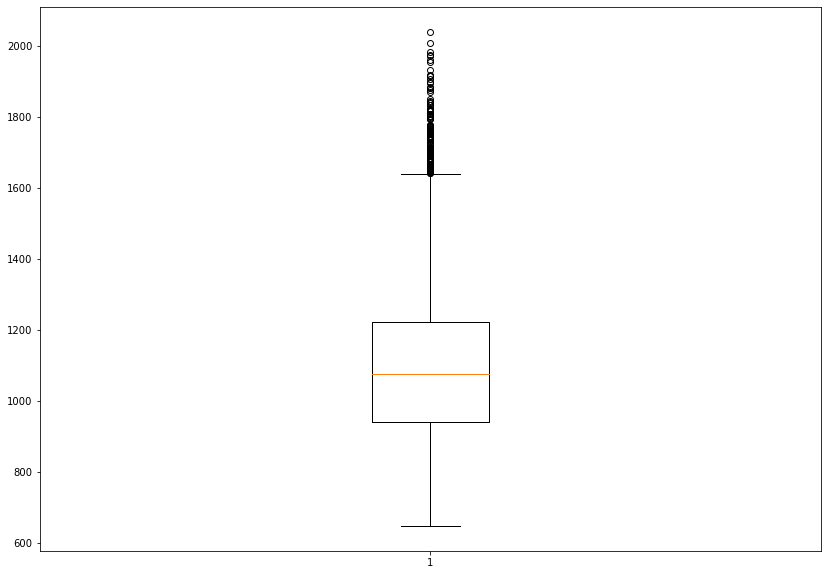

In [142]:
plt.figure(figsize=(14,10))
plt.boxplot(data['PT08.S1(CO)']);

In [143]:
#IQR Yöntemi kullanılarak aykırı veriler sınır değerlerine taşınmıştır

Q1_S1 = data['PT08.S1(CO)'].quantile(0.25)
Q3_S1 = data['PT08.S1(CO)'].quantile(0.75)
IQR_S1 = Q3_S1 - Q1_S1

In [144]:
Q3_S1 + 1.5*IQR_S1

1641.0

In [145]:
S1_max = Q3_S1 + 1.5*IQR_S1

In [146]:
Q1_NO = data['NOx(GT)'].quantile(0.25)
Q3_NO = data['NOx(GT)'].quantile(0.75)
IQR_NO = Q3_NO - Q1_NO

In [147]:
NO_max = Q3_NO + 1.5*IQR_NO
NO_max, S1_max

(542.0, 1641.0)

In [148]:
NO_datas = data['NOx(GT)']
NO_datas[NO_datas > NO_max] = NO_max
data['NOx(GT)'] = NO_datas

In [149]:
S1_datas = data['PT08.S1(CO)']
S1_datas[S1_datas > S1_max] = S1_max
data['PT08.S1(CO)'] = S1_datas

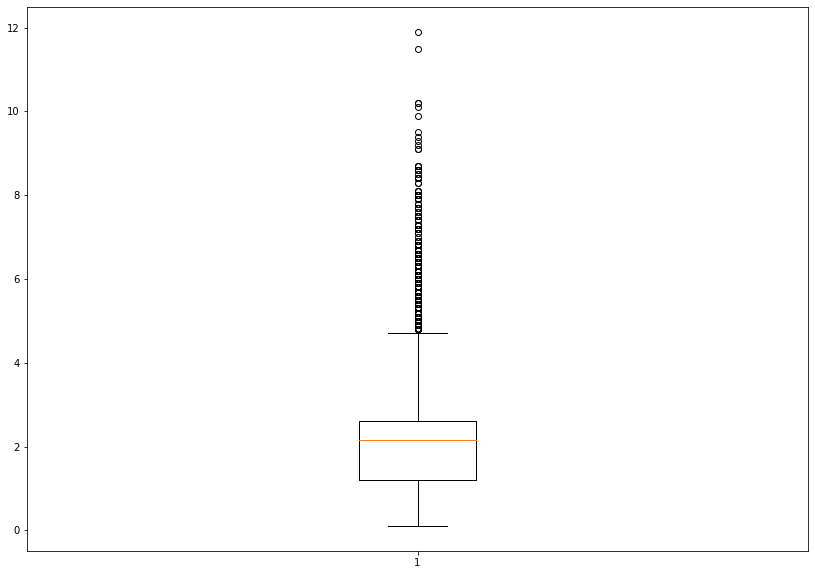

In [150]:
#Sınır değerlerine taşınan verilerin boxplot grafiği çizilerek kontrol edilmiştir

plt.figure(figsize=(14,10))
plt.boxplot(data['CO(GT)']);
plt.savefig("NOx_notOut")

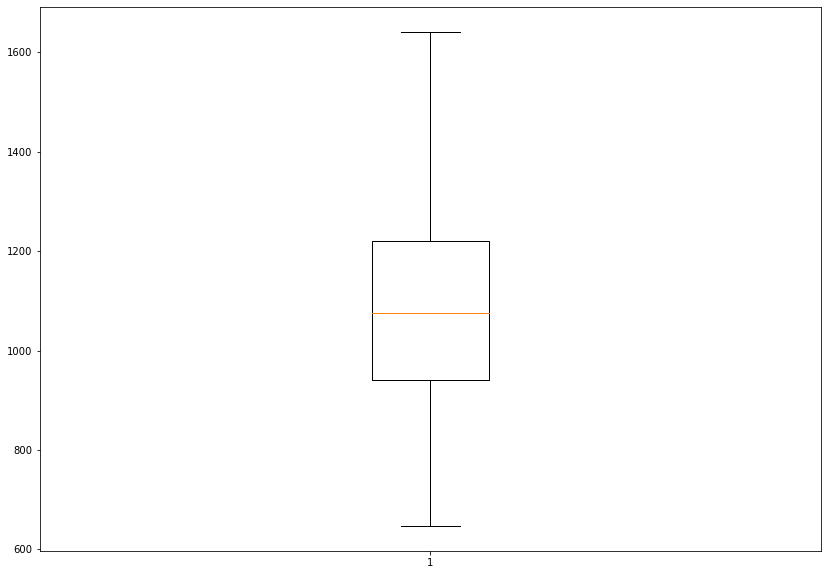

In [151]:
plt.figure(figsize=(14,10))
plt.boxplot(data['PT08.S1(CO)']);

In [152]:
#Tarih içerikli sütunlar silinmiştir

data = data.drop(labels=['Date','Time'], axis =1)
X = data.drop('T', 1)
y = data['T']

In [153]:
#train_test-split fonksiyonu ile veri seti x ve y değerlerine ayrılmıştır

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

In [154]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7485, 9), (1872, 9), (7485,), (1872,))

In [155]:
#RandomForestRegressor ile max derinliği 3 olan model oluşturulmuştur

rnd_reg = RandomForestRegressor(n_estimators=20, max_depth=3, oob_score=True)

In [156]:
#Model X_train ve y_train setleri ile eğitilmiştir

rnd_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=20, oob_score=True)

In [157]:
#X_test seti ile model tahmin ettirilmiştir

y_pred = rnd_reg.predict(X_test)

In [158]:
#Tahmin değerleri ekrana yazılmıştır

y_pred

array([17.14207557, 28.1138427 , 15.44276797, ..., 15.85835628,
       15.44276797, 28.48307784])

In [159]:
# Test değerleri ekrana yazılmıştır

y_test

3349    20.9
5038    29.6
8969    14.5
7329    12.8
173     16.0
        ... 
4011    27.5
3047    35.5
6776    12.4
6959    11.4
4030    36.3
Name: T, Length: 1872, dtype: float64

In [160]:
#Tahmin ve test değerlerinden oluşan bir dataframe oluşturulmuştur

pd.DataFrame(data = { "Gerçek değer":y_test,"Tahmin edilen":y_pred})

,Gerçek değer,Tahmin edilen
3349,20.9,17.142076
5038,29.6,28.113843
8969,14.5,15.442768
7329,12.8,15.858356
173,16.0,15.442768
...,...,...
4011,27.5,22.529962
3047,35.5,35.157980
6776,12.4,15.858356
6959,11.4,15.442768


In [161]:
#Regresyon skoru görüntülenmiştir

rnd_reg.score(X_train, y_train), rnd_reg.score(X_test, y_test)

(0.8474896726534671, 0.8395228212966415)

In [162]:
#Oob skoru görüntülenmiştir

rnd_reg.oob_score_

0.8353296841938295

In [163]:
rnd_reg.oob_prediction_

array([22.69292104,  7.42302442, 22.69159775, ...,  9.07075469,
       28.00535016, 30.04195186])

In [164]:
#R^2 skoru görüntülenmiştir

r2_score(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)

(0.8395228212966415, 2.8961721828169185, 12.185388474381803)

In [165]:
#Pca değişkeni oluşturulmuş ve veriseti için fit edilmiştir

pca = PCA()
pca.fit(data)

PCA()

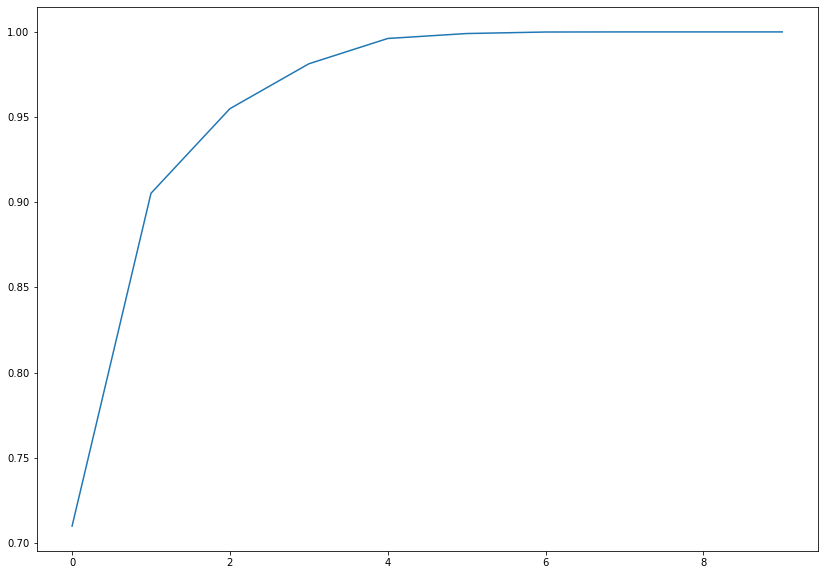

In [166]:
#Varyans grafiği çizilmiştir

plt.figure(figsize=(14,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.savefig("PCA")

In [167]:
#4 adet boyutun varyansı büyük ölçüde koruyarak boyutların indirgenebileceği anlaşılmıştır

pca = PCA(n_components=4)
pca_rnd_reg = pca.fit_transform(data)

In [168]:
pca_rnd_reg.shape

(9357, 3)

In [169]:
pca_rnd_reg

array([[-165.08831984,  237.39502184,  240.68317518],
       [  33.10397115,  267.22348205,  246.17012973],
       [ -33.34722091,  202.79816973,  294.88440361],
       ...,
       [  11.16284092, -314.00875628,  -96.42836466],
       [ 277.5333192 , -322.54042996, -136.83386633],
       [ 154.24474307, -325.40611756, -115.87826471]])

In [170]:
#PCA yapıldıktan sonra yeni bir model oluşturulmuştur
pca_rnd_reg = RandomForestRegressor(n_estimators=20, max_depth=3, oob_score=True)

In [171]:
#Model eğitilmiştir

pca_rnd_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=20, oob_score=True)

In [172]:
#Modele tahmin ettirilmiş ve bu değerler y_pred adlı değişkene kaydedilmiştir

pca_y_pred = rnd_reg.predict(X_test)

In [173]:
#Tahmin edilen ve gerçek değerler için yeni bir veri çerçevesi kullanılmıştır

pd.DataFrame(data = { "Gerçek değer":y_test,"Tahmin edilen":y_pred, "Fark":y_test-y_pred})

,Gerçek değer,Tahmin edilen,Fark
3349,20.9,17.142076,3.757924
5038,29.6,28.113843,1.486157
8969,14.5,15.442768,-0.942768
7329,12.8,15.858356,-3.058356
173,16.0,15.442768,0.557232
...,...,...,...
4011,27.5,22.529962,4.970038
3047,35.5,35.157980,0.342020
6776,12.4,15.858356,-3.458356
6959,11.4,15.442768,-4.042768


In [174]:
#Aşağıda modelin metriklerine bakılmıştır

pca_rnd_reg.score(X_train, y_train), pca_rnd_reg.score(X_test, y_test)

(0.8501527734811084, 0.8440419775231813)

In [175]:
r2_score(y_test, pca_y_pred), mean_absolute_error(y_test, pca_y_pred), mean_squared_error(y_test, pca_y_pred)

(0.8395228212966415, 2.8961721828169185, 12.185388474381803)

In [176]:
data.head()

,CO(GT),PT08.S1(CO),NMHC(GT),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),T,RH,AH
0,2.6,1360.0,150.0,166.0,1056.0,113.0,1692.0,13.6,48.9,0.7578
1,2.0,1292.0,112.0,103.0,1174.0,92.0,1559.0,13.3,47.7,0.7255
2,2.2,1402.0,88.0,131.0,1140.0,114.0,1555.0,11.9,54.0,0.7502
3,2.2,1376.0,80.0,172.0,1092.0,122.0,1584.0,11.0,60.0,0.7867
4,1.6,1272.0,51.0,131.0,1205.0,116.0,1490.0,11.2,59.6,0.7888


In [177]:
#Modelin tahmin etmesi için yeni bir veri oluşturulmuştur

newdatas = [[3.1,1200,130,166,900,75,1800,45,0.82],
                        [2.8,1400,160,130,1200,100,1400,70,0.35]]

In [178]:
newdatas

[[3.1, 1200, 130, 166, 900, 75, 1800, 45, 0.82],
 [2.8, 1400, 160, 130, 1200, 100, 1400, 70, 0.35]]

In [179]:
#Yeni veri ile modele tahmin ettirilmiştir

pca_rnd_reg.predict(newdatas)

array([12.77071763,  6.82899207])

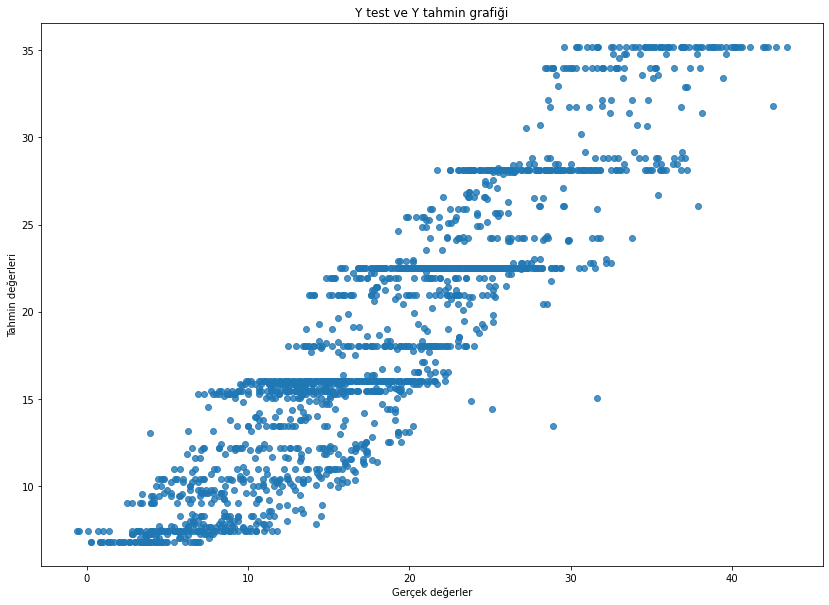

In [180]:
#Scatter ile tahmin ve gerçek değerleri ekrana yazdırılmıştır

plt.figure(figsize=(14,10))
plt.scatter(y_test, y_pred, alpha=0.8)
plt.xlabel("Gerçek değerler")
plt.ylabel("Tahmin değerleri")
plt.title("Y test ve Y tahmin grafiği");


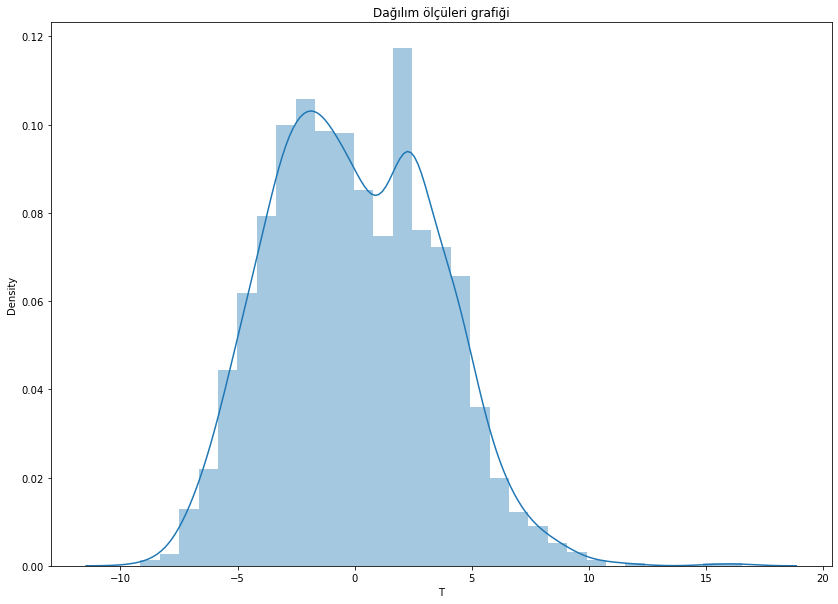

In [181]:
#Dağılım ölçüleri grafiği 

plt.figure(figsize=(14,10))
sns.distplot(y_test-y_pred);
plt.title("Dağılım ölçüleri grafiği");
plt.savefig("distplot")